In [1]:
# import common bib
import numpy as np
import pandas as pd
from google.colab import auth
auth.authenticate_user()

import matplotlib.pyplot as plt

import gspread
from google.auth import default
creds, _ = default()

from urllib.request import urlopen
from urllib.parse import quote

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

!pip install --upgrade gspread

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 KB 3.4 MB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2


In [2]:
# create a dictionary with types of organic compounds 
# the order affects the main join class in the new column
Classes_Org = {
               'S': 'S',
               'N' : 'N',
               'c3' : 'Three_Aroma',
               'c2' : 'Bi_Aroma',
               'c1' : 'Aroma',
               'C3' : 'Three_Cyclo', 
               'C2' : 'Bi_Cyclo',
               'C1' : 'Cyclo', 
               '#': 'Alkyne',
               'c' : 'Aroma',
               '=' : 'Alkene',
               '(C' : 'ISO',
               'C' : 'Alkane',
               "unknown" : "unknown"
               }

In [29]:
# Import Ur table in dictionary and give is name
tables = {'758':'https://docs.google.com/spreadsheets/d/1rkQ6iacKAdCopgpLJvxYX-L0djXsEwHtcZUS-XKEaR0/edit?usp=sharing', #758
          #name_dataframe : 'url_google_table'
          } 

In [30]:
#First row with data
first_row = 7

In [5]:
def imoprt_table(url,sheet):
  gc = gspread.authorize(creds)

  wb = gc.open_by_url(url)
  ws = wb.worksheet(sheet)
  rows = ws.get_all_values()

  ds = pd.DataFrame.from_records(rows)

  ds.columns = ds.loc[6]
  ds = ds.loc[first_row:]
  print('Файл прочитан')
  def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return "unknown" 
  
  ds['Smiles'] = ds['Library/ID'].apply(lambda x: CIRconvert(x))
  print("Подгрузил Smile")

  def types_of(mol):
    result = []
    for i in Classes_Org:
      if mol.find(i) != -1 and Classes_Org[i] not in result:
        result.append(Classes_Org[i])
    return result[0]
  print("Классификация соединения выполнена")
  ds['type'] = ds['Smiles'].apply(lambda x : types_of(x))
  
  def count_c(c):
    result = c.count('C') + c.count('c')
    return result
  
  ds['sum_c'] = ds['Smiles'].apply(lambda x : count_c(x))
  print("Посчитал количество С")

  for i in ds['type'].unique():
    ds[i] = 0
  for i in range(len(ds)):
    obj = ds.iloc[i]
    stry = obj['type']
    obj[stry] = obj['Area Pct']
    ds.iloc[i] = obj 

  return ds

In [6]:
result = {}
for i in tables:
  print("Читаю фаил:",i)
  result[i] = imoprt_table(tables[i],'RESULTS.CSV')

Читаю фаил: 758
Файл прочитан
Подгрузил Smile
Классификация соединения выполнена
Посчитал количество С


In [7]:
def data_mine(file_name, type = None):
  res=[]

  for i in file_name:
    if type == None:
      res.extend(result[i]['sum_c'])
    else:
      res.extend(result[i][result[i]['type']==type]['sum_c'])
  res = sorted(res)
  pop = pd.DataFrame(data=res,columns = ['C'])
  pop['count'] = 1
  pop = pop.groupby(by='C').count()
  return pop

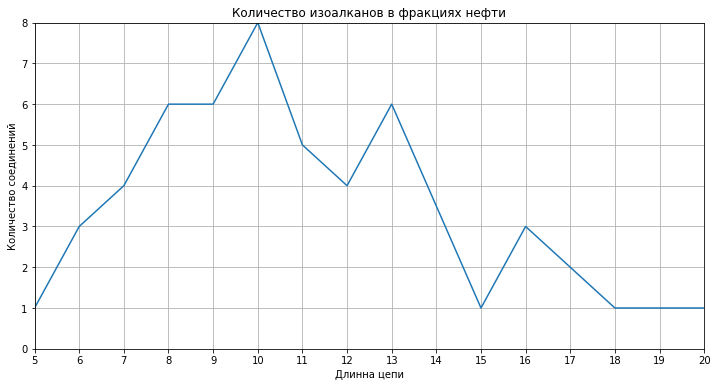

In [28]:
isx = data_mine(result,"ISO")
fig = plt.figure(figsize=(12, 6))
plt.plot(isx,label = 'Исходная нефть')
plt.xlabel("Длинна цепи")
plt.ylabel("Количество соединений")
plt.title("Количество изоалканов в фракциях нефти")
plt.xlim(5,20)
plt.ylim (0,8)
plt.grid()
plt.locator_params (axis='x', nbins= 20)